本次作业以垃圾邮件分类任务为基础，要求提取文本特征并使用朴素贝叶斯算法进行垃圾邮件识别（调用已有工具包或自行实现）。

### 任务介绍
电子邮件是互联网的一项重要服务，在大家的学习、工作和生活中会广泛使用。但是大家的邮箱常常被各种各样的垃圾邮件填充了。有统计显示，每天互联网上产生的垃圾邮件有几百亿近千亿的量级。因此，对电子邮件服务提供商来说，垃圾邮件过滤是一项重要功能。而朴素贝叶斯算法在垃圾邮件识别任务上一直表现非常好，至今仍然有很多系统在使用朴素贝叶斯算法作为基本的垃圾邮件识别算法。

本次实验数据集来自[Trec06](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo06)的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。

本次实验

基本要求：
1. 提取正文部分的文本特征；
2. 划分训练集和测试集（可以借助工具包。一般笔记本就足够运行所有数据，认为实现困难或算力不够的同学可以采样一部分数据进行实验。）；
3. 使用朴素贝叶斯算法完成垃圾邮件的分类与预测，要求测试集准确率Accuracy、精准率Precision、召回率Recall均高于0.9（本次实验可以使用已有的一些工具包完成如sklearn）；
4. 对比特征数目（词表大小）对模型效果的影响；
5. 提交代码和实验报告。

扩展要求：
1. 邮件头信息有时也可以协助判断垃圾邮件，欢迎学有余力的同学们尝试；
2. 尝试自行实现朴素贝叶斯算法细节；
3. 尝试对比不同的概率计算方法。

### 导入工具包

In [1]:
'''
提示：
若调用已有工具包，sklearn中提供了一些可能会用到的类。
'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # 提取文本特征向量的类
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB # 三种朴素贝叶斯算法，差别在于估计p(x|y)的方式
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jieba, os, re


### 数据集读取与划分

In [38]:
def load_label(idx_path=r'./trec06c-utf8/label/index'):
    """
    读取数据集至内存中，并按照（标签，邮件头，正文）划分，返回三个列表
    """
    labels = []
    headers = []
    datas = []
    with open(idx_path, 'r', encoding='utf-8') as f:
        idx = [line.replace('data', 'data_cut').strip('\n') for line in f]
        for line in idx:
            label, path = line.split(' ')
            labels.append(1 if label == 'spam' else 0)
            with open(os.path.join(idx_path+'/../', path), 'r', encoding='utf-8') as email:
                head, data = email.read().split('\n\n', maxsplit=1)
                headers.append(head)
                datas.append(data)
        return labels, headers, datas

labels, headers, datas = load_label()


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    datas, labels, test_size=0.2, random_state=20020104)
H_train, H_test, y_train, y_test = train_test_split(
    headers, labels, test_size=0.2, random_state=20020104)


In [43]:
def extra_fea(X_train, X_test, min_df=0.1, max_df=1.0, max_features=100, method='count'):
    '''
    对正文部分进行特征提取，指定方法：
        count不考虑词频，tfidf考虑词频，使用tfidf计算
    '''
    if method=='count':
        cv = CountVectorizer(
            min_df=min_df, max_df=max_df, max_features=max_features)
    elif method == 'tfidf':
        cv = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, ngram_range=(1, 1))
    cv_model = cv.fit(X_train)
    features_name = cv_model.get_feature_names()
    features_train = cv_model.transform(X_train).toarray()
    features_test = cv_model.transform(X_test).toarray()
    return features_name, features_train, features_test



In [60]:
def draw_cloud(features_train, features_name, limits_count=100):
    """
    绘制词云，可视化
    """
    df = pd.DataFrame(features_train, columns=features_name)
    df.describe()
    word_counts = dict(df.mean())
    # 绘制词云
    my_cloud = WordCloud(
        background_color='white', # 设置背景颜色  默认是black
        width=900, height=600,
        max_words=limits_count,   # 词云显示的最大词语数量
        font_path='simhei.ttf',   # 设置字体  显示中文
        max_font_size=99,         # 设置字体最大值
        min_font_size=16,         # 设置子图最小值
        random_state=50           # 设置随机生成状态，即多少种配色方案
    ).generate_from_frequencies(word_counts)

    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


绘制词云查看特征词，发现无意义特征词（表示价格的数字，连接词，语气词，停用词）并不多，无须单独处理。

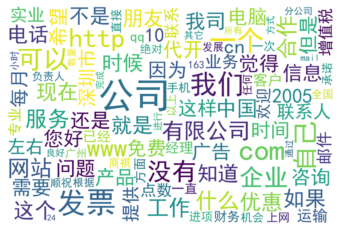

In [47]:
features_name, features_train, features_test = extra_fea(X_train, X_test, method='tfidf')
draw_cloud(features_train, features_name)


### 模型构建
差异大部分来自于处理 $P(x_i \mid y)$ 分布时的所做的假设不同
- 多项式朴素贝叶斯分类器：特征变量是离散变量，符合多项分布，在文档分类中特征变量体现在一个单词出现的次数，或者是单词的 TF-IDF 值等。
- 伯努利朴素贝叶斯分类器：模型适用于多元伯努利分布，即每个特征都是二值变量，如果不是二值变量，该模型可以先对变量进行二值化，在文档分类中特征是单词是否出现，如果该单词在某文件中出现了即为1，否则为0。在文本分类的示例中，统计词语**是否出现的向量**(而非统计词语出现次数的向量)可以用于训练和使用这个分类器。
- 补码朴素贝叶斯分类器：专用于离散数据集，它假定由索引描述的每个特征都有其自己的分类分布。对于训练集中的每个特征 X，CategoricalNB估计以类y为条件的X的每个特征i的分类分布。

首先对2种特征的提取方式，和3种模型进行粗略对比：

In [61]:
clf1 = MultinomialNB(alpha=1)
clf2 = BernoulliNB()
clf3 = ComplementNB()


In [150]:
for method in ['count', 'tfidf']:
    features_name, features_train, features_test = extra_fea(
        X_train, X_test, method=method)
    for me_name, model in zip(['MultinomialNB', 'BernoulliNB', 'ComplementNB'], [clf1, clf2, clf3]):
        model.fit(features_train, y_train)
        y_pred = model.predict(features_test)
        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        print(me_name+':  '+'accuracy '+str(accuracy) +
            '  precision '+str(precision)+'  recall '+str(recall))


MultinomialNB:  accuracy 0.9141906530485918  precision 0.932956381260097  recall 0.9386973180076629
BernoulliNB:  accuracy 0.91991643454039  precision 0.9692841218726778  recall 0.9086264948333914
ComplementNB:  accuracy 0.9110182606004333  precision 0.9610774743605585  recall 0.9030535237431789
MultinomialNB:  accuracy 0.9152739090064995  precision 0.9290116411778133  recall 0.9450830140485313
BernoulliNB:  accuracy 0.91991643454039  precision 0.9692841218726778  recall 0.9086264948333914
ComplementNB:  accuracy 0.9071494893221913  precision 0.9658162624104562  recall 0.8922558922558923


### 参数优化

在相关论文的参考报告中提及：

Email is not just text; it has structure. Spam filtering is not just classification, because false positives are so much worse than false negatives that you should treat them as a different kind of error. 


我们倾向于“预测为垃圾邮件的一定为垃圾邮件”，而不是“所有垃圾邮件都被识别”，也就是**precicion比recall指标更重要**。


最终选择**考虑词频+BernoulliNB模型**，即在特征划分时较多的词分辨率低，拟合时只关注当前特征词是否出现，而不关心出现过多少次。
 


下面观察取不同个数特征带来的变化：随着特征数的增多，准确率呈现先上升后下降的趋势。

体现在了precision的不断上升和recall的不断下降，也就是部分垃圾邮件没有被识别出来。分析原因，伯努利分布中过多特征带来的混淆较为严重，即垃圾邮件中出现的关键词占比随着特征数增加，其占比变小。

In [159]:
max_features = [10, 30, 50, 100, 300, 500, 1000, 2000]
accuracys, precisions, recalls = [],[],[]
for _max_feature in max_features:
    print('max_feature: {:.1f}'.format(_max_feature))
    features_name, features_train, features_test = extra_fea(
        X_train, X_test, max_features=_max_feature, method='tfidf')
    clf2.fit(features_train, y_train)
    y_pred = clf2.predict(features_test)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    accuracys.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    print('accuracy '+str(accuracy) +
            '  precision '+str(precision)+'  recall '+str(recall))


max_feature: 10.0
accuracy 0.8897400185701021  precision 0.9595907928388747  recall 0.8712411471032161
max_feature: 30.0
accuracy 0.91991643454039  precision 0.9692841218726778  recall 0.9086264948333914
max_feature: 50.0
accuracy 0.9247137109254101  precision 0.973123606638593  recall 0.9122257053291536
max_feature: 100.0
accuracy 0.8730269266480966  precision 0.9788461538461538  recall 0.8273539997677929
max_feature: 300.0
accuracy 0.8559269575982668  precision 0.9821454077988859  recall 0.7983281086729362
max_feature: 500.0
accuracy 0.8559269575982668  precision 0.9821454077988859  recall 0.7983281086729362
max_feature: 1000.0
accuracy 0.8559269575982668  precision 0.9821454077988859  recall 0.7983281086729362
max_feature: 2000.0
accuracy 0.8559269575982668  precision 0.9821454077988859  recall 0.7983281086729362


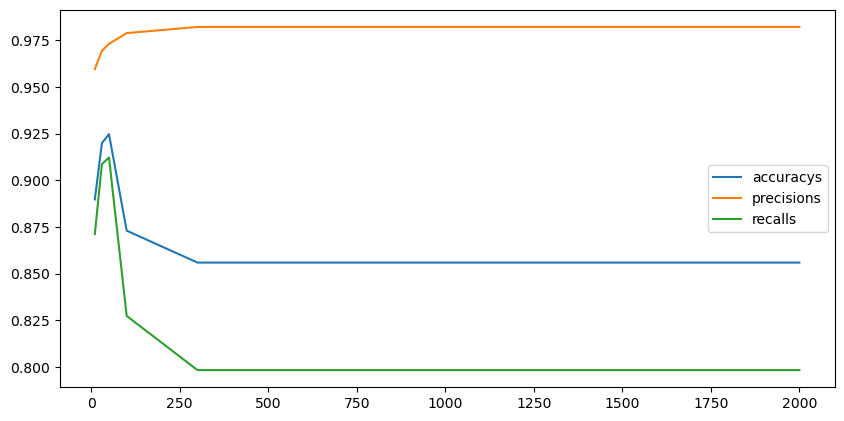

In [163]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(max_features, accuracys, label='accuracys')
plt.plot(max_features, precisions, label='precisions')
plt.plot(max_features, recalls, label='recalls')
plt.legend()
plt.show()


### 模型优化

And the source of error is not just random variation, but a live human spammer working actively to defeat your filter.
论文的作者提出如下改进：

1. token的数目，并非使用全部，使用部分。已实现。
2. 标点符号的考虑。“Letters, digits, dashes, apostrophes, and dollar signs are constituent characters, and everything else is a token separator. ”。但是，如果引入标点，很有可能导致一些由于过拟合（譬如，FREE后跟随7个感叹号不会被作为特征，因为其出现概率不大）带来的失误。通过“degeneration”的方法解决，即如果未找到对应特征，则按照前缀/后缀相同的特征的可能性，取最远的一个。
3. 数字的考虑。将ip，价格作为单独的特征进行处理。
4. 大小写的考虑。这点在中文文本中的体现并不明显。
5. 考虑词频而不仅仅是概率，即少量的词汇的置信程度应该被降低。
6. 对于html的讨论，不能忽略或单纯识别，而是通过url或图片作为特征。
7. 对邮件头的处理。这里针对recall结果不断下降的问题做出优化，提取最常见的垃圾邮件的发件方，将来自这些发送方的邮件直接认定为垃圾邮件。但这个方法疏漏了许多垃圾邮件商通过中间商发送，而非自身服务器。但效果欠佳。

In [ ]:
# from collections import Counter

# senders = []
# for idx, head in enumerate(H_train):
#     if y_train[idx]==1:
#         mes = head.split('\n')[:]
#         for _ in mes:
#             if 'From' in _:
#                 senders.append(_)
# spam_dic = Counter(senders)

# features_name, features_train, features_test = extra_fea(
#     X_train, X_test, max_features=300, method='tfidf')
    
# clf2.fit(features_train, y_train)
# y_pred = clf2.predict(features_test)
# for idx, head in enumerate(H_test):
#     if y_pred[idx] == 0:
#         mes = head.split('\n')[:]
#         for _ in mes:
#             if _ in spam_dic and spam_dic[_]>=15:
#                 y_pred[idx]=1

# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(y_true=y_test, y_pred=y_pred)
# recall = recall_score(y_true=y_test, y_pred=y_pred)
# print('accuracy '+str(accuracy) +
#       '  precision '+str(precision)+'  recall '+str(recall))




尚且存在两类待优化：
1. 与职业相关的邀请。url的重复次数可以作为一个特征。
2. 以日常对话，邀请聊天的形式发起的色情网站邮件。